In [1]:
import warnings
warnings.simplefilter('ignore')

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import tree
import os
import pickle

import io
import scipy.stats
import scipy.special
import seaborn as sns

In [2]:
# Read the csv file into a pandas DataFrame

loan_df = pd.read_csv('UpdatedLoan_Dataset.csv')
loan_df

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


In [3]:
loan_df = loan_df.dropna()
loan_df

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
5,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


In [4]:
loan_df["TotalHouseholdIncome"] = loan_df["ApplicantIncome"] + loan_df["CoapplicantIncome"]

In [5]:
loan_df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,TotalHouseholdIncome
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N,6091.0
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y,3000.0
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y,4941.0
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y,6000.0
5,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y,9613.0


In [9]:
# Assign X (data) and y (target)
X = loan_df[['TotalHouseholdIncome', 'Credit_History', 'Property_Area', 'Gender', 'Married', 'Education', 'Loan_Amount_Term', 'LoanAmount' ]]
# X = loan_df[['TotalHouseholdIncome', 'Property_Area', 'Married', 'Education']]
y = loan_df["Loan_Status"]
print(X.shape, y.shape)

(480, 8) (480,)


In [10]:
loan_df.dtypes

Loan_ID                  object
Gender                   object
Married                  object
Dependents               object
Education                object
Self_Employed            object
ApplicantIncome           int64
CoapplicantIncome       float64
LoanAmount              float64
Loan_Amount_Term        float64
Credit_History          float64
Property_Area            object
Loan_Status              object
TotalHouseholdIncome    float64
dtype: object

In [14]:
cleanup_nums = {"Property_Area": {"Rural": 0, "Urban": 1, "Semiurban":2},
               "Gender": {"Male": 0, "Female": 1},
               "Education": {"Graduate":1, "Not Graduate": 0},
               "Married": {"Yes": 1, "No":0},
                "Self_Employed": {"Yes": 1, "No": 0},
                "Loan_Status": {"Y": 1, "N": 0} 
               }
print(cleanup_nums)

{'Property_Area': {'Rural': 0, 'Urban': 1, 'Semiurban': 2}, 'Gender': {'Male': 0, 'Female': 1}, 'Education': {'Graduate': 1, 'Not Graduate': 0}, 'Married': {'Yes': 1, 'No': 0}, 'Self_Employed': {'Yes': 1, 'No': 0}, 'Loan_Status': {'Y': 1, 'N': 0}}


In [16]:
#X.fillna(0, inplace=True)

In [17]:
y.isna().sum()

0

In [18]:
X.replace(cleanup_nums, inplace=True)
X


,TotalHouseholdIncome,Credit_History,Property_Area,Gender,Married,Education,Loan_Amount_Term,LoanAmount
1,6091.0,1.0,0,0,1,1,360.0,128.0
2,3000.0,1.0,1,0,1,1,360.0,66.0
3,4941.0,1.0,1,0,1,0,360.0,120.0
4,6000.0,1.0,1,0,0,1,360.0,141.0
5,9613.0,1.0,1,0,1,1,360.0,267.0
...,...,...,...,...,...,...,...,...
609,2900.0,1.0,0,1,0,1,360.0,71.0
610,4106.0,1.0,0,0,1,1,180.0,40.0
611,8312.0,1.0,1,0,1,1,360.0,253.0
612,7583.0,1.0,1,0,1,1,360.0,187.0


In [20]:
y.replace({"Y": 1, "N": 0}, inplace=True)
y

1      0
2      1
3      1
4      1
5      1
      ..
609    1
610    1
611    1
612    1
613    0
Name: Loan_Status, Length: 480, dtype: int64

In [21]:
# Split the data into training and testing

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


In [22]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScater model and fit it to the training data

X_scaler = StandardScaler().fit(X_train)
# y_scaler = StandardScaler().fit(y_train)


In [23]:
# Transform the training and testing data using the X_scaler and y_scaler models

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
#y_train_scaled = y_scaler.transform(y_train)
#y_test_scaled = y_scaler.transform(y_test)


In [60]:
# # Create a LinearRegression model and fit it to the scaled training data

from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train_scaled, y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

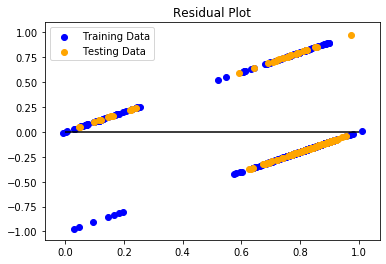

In [61]:
# # Make predictions using a fitted model
# # Plot the difference between the model predicted values and actual y values, versus the model predicted values
# # Hint: You can predict values of X training and testing data using the model.predict() method on a fitted model

predictions = model.predict(X_test_scaled)
# model.fit(X_train, y_train)
plt.scatter(model.predict(X_train_scaled), model.predict(X_train_scaled) - y_train, c="blue", label="Training Data")
plt.scatter(model.predict(X_test_scaled), model.predict(X_test_scaled) - y_test, c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max())
plt.title("Residual Plot")
plt.show()

In [56]:
# # Used X_test_scaled, y_test_scaled, and model.predict(X_test_scaled) to calculate MSE and R2

from sklearn.metrics import mean_squared_error

MSE = mean_squared_error(y_test, predictions)
r2 = model.score(X_test, y_test)

print(f"MSE: {MSE}, R2: {r2}")

MSE: 0.41859107044439103, R2: 0.28476058768015444


In [57]:
# #print(model.predict(X_test_scaled))
print((y_test))

92     1
529    1
505    1
358    0
512    1
      ..
71     1
225    0
373    0
515    1
32     0
Name: Loan_Status, Length: 120, dtype: int64


In [65]:
print (y_test)

92     1
529    1
505    1
358    0
512    1
      ..
71     1
225    0
373    0
515    1
32     0
Name: Loan_Status, Length: 120, dtype: int64


In [29]:
from scipy import stats

Loan_Status             1.000000
Credit_History          0.529390
LoanAmount              0.071753
TotalHouseholdIncome    0.062465
CoapplicantIncome       0.049020
ApplicantIncome         0.043152
Loan_Amount_Term        0.007798
Name: Loan_Status, dtype: float64


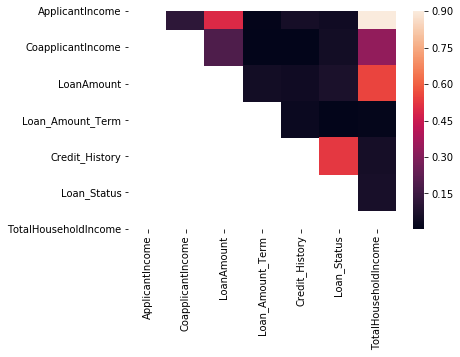

In [30]:
import seaborn as sns
corr_matrix = loan_df.corr().abs()

print(corr_matrix['Loan_Status'].sort_values(ascending=False).head(10))
# Select upper triangle of correlation matrix
matrix = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
sns.heatmap(matrix)
plt.show;



In [81]:
loan = tree.DecisionTreeClassifier(max_depth=5)
loan = loan.fit(X_train, y_train)
loan.score(X_test, y_test)

0.7833333333333333

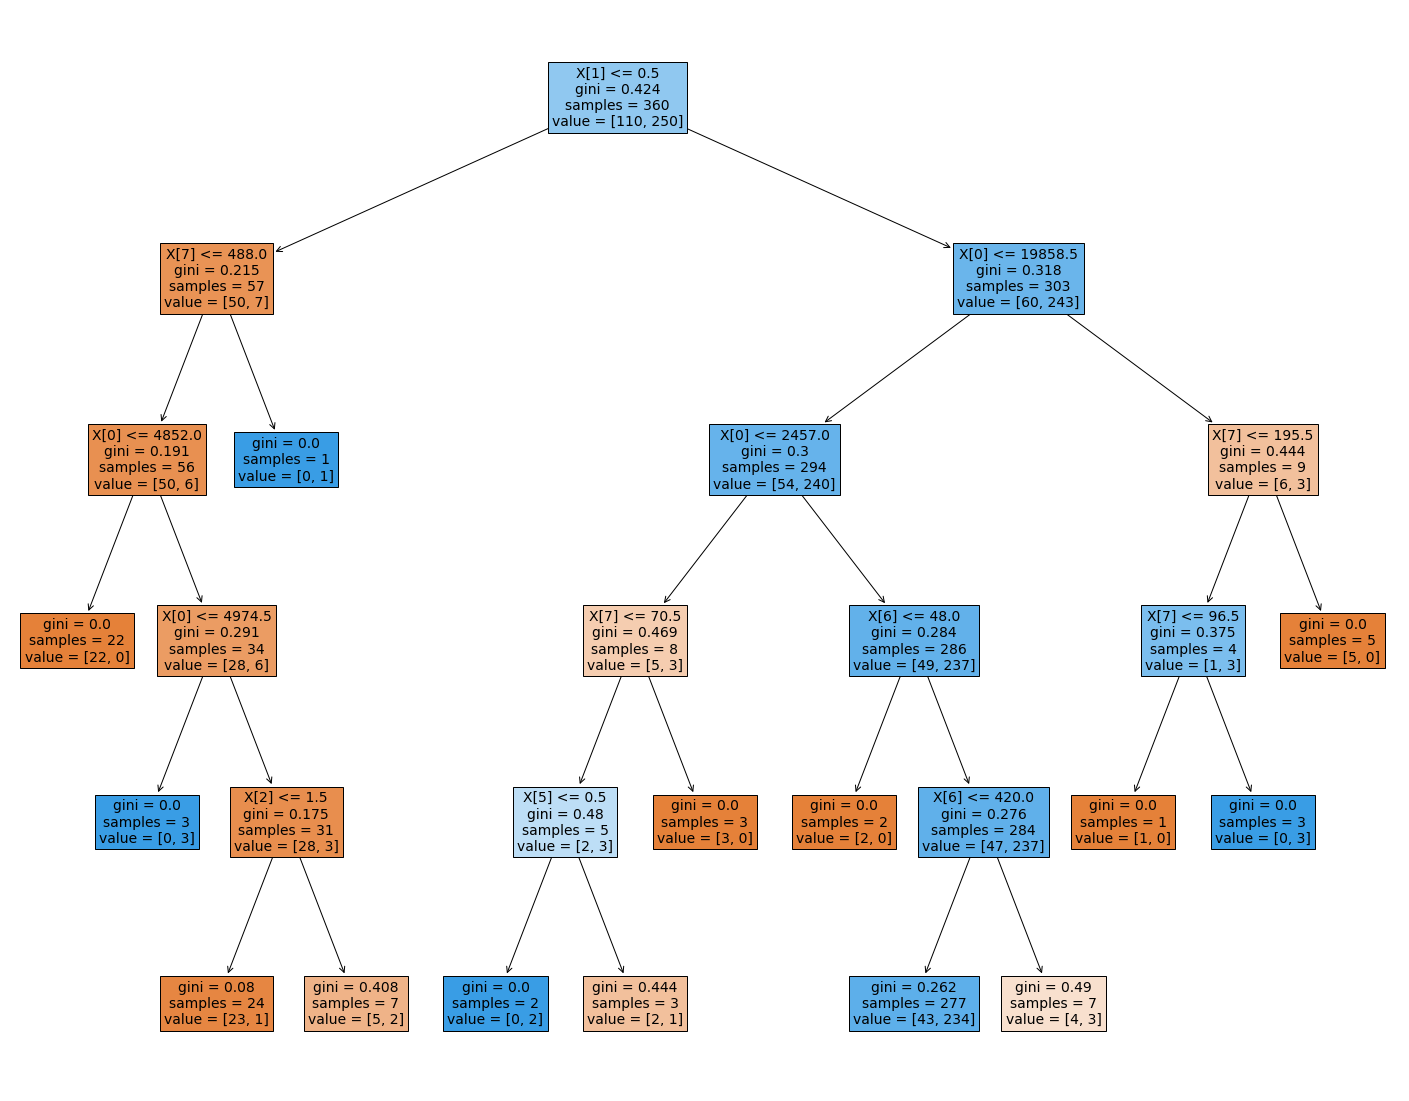

In [82]:
plt.show()
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(loan, filled=True) 
                  


In [32]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=200)
rf = rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.75

In [33]:
sorted(zip(rf.feature_importances_, X.columns), reverse=True)

[(0.2806626195116736, 'TotalHouseholdIncome'),
 (0.2669350127594078, 'LoanAmount'),
 (0.2602300627422815, 'Credit_History'),
 (0.06134874720209578, 'Loan_Amount_Term'),
 (0.052795886845479326, 'Property_Area'),
 (0.030601764945059496, 'Married'),
 (0.024584651169872324, 'Education'),
 (0.022841254824130332, 'Gender')]

In [66]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [67]:
classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [68]:
print(f"Training Data Score: {classifier.score(X_train, y_train)}")
print(f"Testing Data Score: {classifier.score(X_test, y_test)}")

Training Data Score: 0.8166666666666667
Testing Data Score: 0.7916666666666666


In [69]:
predictions = classifier.predict(X_test)
print(f"First 10 Predictions:   {predictions[:10]}")
print(f"First 10 Actual labels: {y_test[:10].tolist()}")

First 10 Predictions:   [1 1 1 0 1 0 1 1 1 1]
First 10 Actual labels: [1, 1, 1, 0, 1, 0, 1, 1, 1, 1]


In [70]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

array([[13, 25],
       [ 0, 82]], dtype=int64)

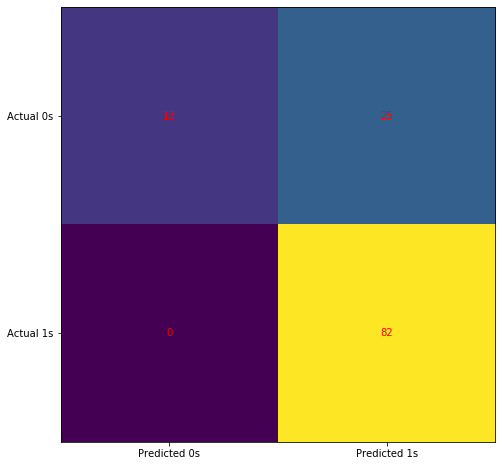

In [76]:
cm = confusion_matrix(y_test, predictions)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()


In [71]:
classifier = LogisticRegression(class_weight = "balanced")
classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [72]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])


Text(0, 0.5, 'Loan Status')

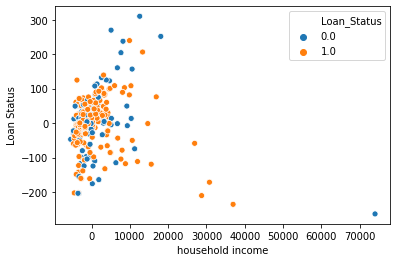

In [52]:
#matplotlib scatter funcion w/ logistic regression 
sns.scatterplot(principalDf["principal component 1"], principalDf["principal component 2"], hue=y)
plt.xlabel("household income")
plt.ylabel("Loan Status")


In [43]:
print(f"Training Data Score: {classifier.score(X_train, y_train)}")
print(f"Testing Data Score: {classifier.score(X_test, y_test)}")

Training Data Score: 0.7944444444444444
Testing Data Score: 0.7416666666666667


In [44]:
pickle.dump(classifier,open("model.sav", "wb"))

loaded_model= pickle.load(open("model.sav","rb"))

predictions = loaded_model.predict(X_test)
print(f"First 10 Predictions:   {predictions[:10]}")

First 10 Predictions:   [1 1 1 0 1 0 1 1 1 1]


In [45]:
print(X_test)

     TotalHouseholdIncome  Credit_History  Property_Area  Gender  Married  \
92                 5093.0             1.0              1       0        1   
529                6783.0             1.0              2       0        0   
505                7926.0             1.0              0       0        1   
358                4666.0             0.0              1       0        1   
512                5318.0             1.0              1       0        1   
..                    ...             ...            ...     ...      ...   
71                 3750.0             1.0              2       0        1   
225                3250.0             1.0              0       0        1   
373                5049.0             0.0              1       0        0   
515                6894.0             1.0              0       0        1   
32                 4692.0             1.0              0       0        0   

     Education  Loan_Amount_Term  LoanAmount  
92           0             3